In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler

# EDA

### Funciones

In [2]:
def select_string_variables(df):
    return df.select_dtypes(include=['object'])

def one_hot_encoding(df, columns):
    """
    Realiza one-hot encoding en un DataFrame y crea banderas para las variables cualitativas.
    
    Args:
        df (pandas.DataFrame): El DataFrame en el que se realizará el encoding.
        columns (list): Una lista de columnas que se deben codificar.
    
    Returns:
        pandas.DataFrame: El DataFrame con las columnas codificadas y las banderas creadas.
    """
    df_encoded = pd.get_dummies(df, columns=columns, prefix=columns, prefix_sep='_')
    
    for column in columns:
        df_encoded[column + '_flag'] = df_encoded[column].apply(lambda x: 1 if pd.notnull(x) else 0)
    
    return df_encoded

def calidad_none(df):
    # Reemplazar 'None' (cadena) con NaN
    df_replaced = df.replace('None', np.nan)
    
    # Contar valores nulos (NaN) en cada columna
    none_counts = df_replaced.isna().sum()
    
    # Crear un DataFrame con los resultados
    result = pd.DataFrame({'Column': none_counts.index, 
                           'None_Count': none_counts.values,
                           'None_Percentage': none_counts.values / len(df) })
    
    return result

def revisar_atipicos(df):
    # Seleccionar solo las columnas numéricas
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Calcular Q1 (primer cuartil) y Q3 (tercer cuartil)
    Q1 = df_numeric.quantile(0.25)
    Q3 = df_numeric.quantile(0.75)
    
    # Calcular IQR (rango intercuartílico)
    IQR = Q3 - Q1
    
    # Identificar valores atípicos
    outliers = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR)))
    
    # Contar valores atípicos por columna
    outliers_count = outliers.sum()
    
    # Crear un DataFrame con los resultados
    result = pd.DataFrame({'Column': outliers_count.index, 
                           'Outliers_Count': outliers_count.values,
                           'Outliers_Percentage': outliers_count.values / len(df) })
    
    return result


def convertir_columnas_a_tipo(df, columnas, tipo):
    """
    Convierte las columnas especificadas de un DataFrame a un tipo de dato específico.

    Parameters:
    df (pd.DataFrame): El DataFrame a modificar.
    columnas (list): Lista de nombres de las columnas a convertir.
    tipo (str or type): El tipo de dato al que se deben convertir las columnas especificadas.

    Returns:
    pd.DataFrame: El DataFrame con las columnas especificadas convertidas.
    """
    df[columnas] = df[columnas].astype(tipo)
    return df



def plot_vs_poblaciones_variable(df, poblaciones, filtro, variable):
    # Lista para almacenar los DataFrames de cada población
    dfs = []
    
    # Realizar las consultas para obtener las poblaciones
    for poblacion in poblaciones:
        cant_poblacion = df[df[filtro] == poblacion][variable]
        df_poblacion = pd.DataFrame({variable: cant_poblacion, 'Poblacion': poblacion})
        dfs.append(df_poblacion)
    
    # Combinar todos los DataFrames
    df_combined = pd.concat(dfs)
    
    # Crear el gráfico
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='Poblacion', y=variable, data=df_combined)
    plt.title(f'Comportamiento de la variable {variable}')
    plt.xlabel('Población')
    plt.ylabel(f'Cantidad de {variable}')
    plt.show()


def plot_violin_vs_poblaciones_variable(df, poblaciones, filtro, variable):
    # Lista para almacenar los DataFrames de cada población
    dfs = []
    
    # Realizar las consultas para obtener las poblaciones
    for poblacion in poblaciones:
        cant_poblacion = df[df[filtro] == poblacion][variable]
        df_poblacion = pd.DataFrame({variable: cant_poblacion, 'Poblacion': poblacion})
        dfs.append(df_poblacion)
    
    # Combinar todos los DataFrames
    df_combined = pd.concat(dfs)
    
    # Crear el gráfico
    plt.figure(figsize=(6, 4))
    sns.violinplot(x='Poblacion', y=variable, data=df_combined)
    plt.title('Comportamiento de la variable {variable}'.format(variable=variable))
    plt.xlabel('Población')
    plt.ylabel('Cantidad de {variable}'.format(variable=variable))
    plt.show()

def plot_densidad_vs_poblaciones_variable(df, poblaciones, filtro, variable):
    # Lista para almacenar los DataFrames de cada población
    dfs = []
    
    # Realizar las consultas para obtener las poblaciones
    for poblacion in poblaciones:
        cant_poblacion = df[df[filtro] == poblacion][variable]
        df_poblacion = pd.DataFrame({variable: cant_poblacion, 'Poblacion': poblacion})
        dfs.append(df_poblacion)
    
    # Combinar todos los DataFrames
    df_combined = pd.concat(dfs)
    
    # Crear el gráfico
    plt.figure(figsize=(6, 4))
    sns.kdeplot(data=df_combined, x=variable, hue='Poblacion', fill=True,common_norm=False)
    plt.title('Comportamiento de la variable {variable}'.format(variable=variable))
    plt.xlabel('Población')
    plt.ylabel('Cantidad de {variable}'.format(variable=variable))
    plt.show()

def comparar_distribuciones(df, tipo_var1, tipo_var2, columna_filtro, columna_valores,prueba='ks'):
    """
    Compara si dos distribuciones son iguales utilizando la prueba de Kolmogorov-Smirnov.

    Parameters:
    df (pd.DataFrame): DataFrame que contiene los datos.
    tipo_var1 (str): Valor del primer tipo de variable a comparar.
    tipo_var2 (str): Valor del segundo tipo de variable a comparar.
    columna_filtro (str): Nombre de la columna para filtrar los tipos de variable.
    columna_valores (str): Nombre de la columna que contiene los valores a comparar.

    Returns:
    dict: Resultado de la prueba KS con el estadístico y el valor p.
    """
    distribucion1 = df[df[columna_filtro] == tipo_var1][columna_valores]
    distribucion2 = df[df[columna_filtro] == tipo_var2][columna_valores]

    if prueba == 'ks':
        estadistico, p_value = ks_2samp(distribucion1, distribucion2)
    elif prueba == 'ttest':
        estadistico, p_value = ttest_ind(distribucion1, distribucion2)
    elif prueba == 'mannwhitneyu':
        estadistico, p_value = mannwhitneyu(distribucion1, distribucion2)

    print(f'Estadístico t: {t_stat}')
    print(f'Valor p: {p_value}')
    
    alpha = 0.05
    if p_value < alpha:
        print("Las poblaciones son significativamente diferentes.")
    else:
        print("No hay evidencia suficiente para decir que las poblaciones son diferentes.")
    
    resultado = {
        'estadistico': estadistico,
        'p_value': p_value,
        'diferentes': p_value < alpha
    }
    
    return resultado





## prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest

#### Lectura y limpieza de dataset 

In [3]:
df_var_rpta_ppal_feature = pd.read_csv('prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')

C:\Users\davzapat\AppData\Local\Temp\ipykernel_3332\715758748.py:1: DtypeWarning: Columns (28,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df_var_rpta_ppal_feature = pd.read_csv('prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv')


In [9]:
df_var_rpta_ppal_feature.head(5)

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,...,porc_pago_cuota,pago_mes,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig
0,630611,219718,863073,202308,1,a_uno_tipo_1,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,...,0.095438,0.0,0.0,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa
1,59412,789567,290775,202312,1,a_uno_tipo_1,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,0.000000,0.0,None,Sin pago,NO,PRORROGA,MANTENIMIENTO,Sin pago,Acepta Alternativa,Acepta Alternativa
2,277595,1045909,34433,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,0.000000,0.0,None,Sin pago,NO,None,None,Sin pago,Acepta Alternativa,Acepta Alternativa
3,26897,585786,494556,202311,1,a_uno_tipo_1,Banca Personas,Personal,ROTATIVOS,Rotativos,...,0.042117,4090.0,0.01532420625107719,Con pago,NO,PRORROGA,MANTENIMIENTO,Pago parcial,Acepta Alternativa,Acepta Alternativa
4,24588,1061389,18953,202311,1,b_uno_tipo_2,Banca Personas,Personal plus,ROTATIVOS,Rotativos,...,0.000000,0.0,0.0,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa


In [10]:
df_var_rpta_ppal_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568251 entries, 0 to 568250
Data columns (total 49 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   nit_enmascarado                  568251 non-null  int64  
 1   num_oblig_orig_enmascarado       568251 non-null  int64  
 2   num_oblig_enmascarado            568251 non-null  int64  
 3   fecha_var_rpta_alt               568251 non-null  int64  
 4   var_rpta_alt                     568251 non-null  int64  
 5   tipo_var_rpta_alt                568251 non-null  object 
 6   banca                            568251 non-null  object 
 7   segmento                         568251 non-null  object 
 8   producto                         568251 non-null  object 
 9   producto_cons                    568251 non-null  object 
 10  aplicativo                       568251 non-null  object 
 11  min_mora                         568251 non-null  int64  
 12  ma

In [11]:
df_var_rpta_ppal_feature.columns

Index(['nit_enmascarado', 'num_oblig_orig_enmascarado',
       'num_oblig_enmascarado', 'fecha_var_rpta_alt', 'var_rpta_alt',
       'tipo_var_rpta_alt', 'banca', 'segmento', 'producto', 'producto_cons',
       'aplicativo', 'min_mora', 'max_mora', 'dias_mora_fin', 'rango_mora',
       'vlr_obligacion', 'vlr_vencido', 'saldo_capital', 'endeudamiento',
       'desc_alternativa1', 'desc_alternativa2', 'desc_alternativa3',
       'cant_alter_posibles', 'alter_posible1_2', 'alter_posible2_2',
       'alter_posible3_2', 'cant_gestiones', 'cant_gestiones_binario', 'rpc',
       'promesas_cumplidas', 'cant_promesas_cumplidas_binario', 'cant_acuerdo',
       'cant_acuerdo_binario', 'descripcion_ranking_mejor_ult',
       'descripcion_ranking_post_ult', 'marca_alt_rank', 'marca_alt_apli',
       'valor_cuota_mes', 'pago_cuota', 'porc_pago_cuota', 'pago_mes',
       'porc_pago_mes', 'pagos_tanque', 'marca_debito_mora',
       'alternativa_aplicada_agr', 'marca_agrupada_rgo', 'marca_pago',
      

In [4]:

df_var_rpta_ppal_feature["llave_modelo"] = df_var_rpta_ppal_feature["nit_enmascarado"].astype(str) + \
                                                    "#" + df_var_rpta_ppal_feature["num_oblig_orig_enmascarado"].astype(str) + \
                                                    "#" + df_var_rpta_ppal_feature["num_oblig_enmascarado"].astype(str)

df_var_rpta_ppal_feature["llave_modelo_2"] = df_var_rpta_ppal_feature["nit_enmascarado"].astype(str) + \
                                                    "#" + df_var_rpta_ppal_feature["num_oblig_orig_enmascarado"].astype(str) 
df_var_rpta_ppal_feature.head(5)

,nit_enmascarado,num_oblig_orig_enmascarado,num_oblig_enmascarado,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,banca,segmento,producto,producto_cons,...,porc_pago_mes,pagos_tanque,marca_debito_mora,alternativa_aplicada_agr,marca_agrupada_rgo,marca_pago,marca_alternativa,marca_alternativa_orig,llave_modelo,llave_modelo_2
0,630611,219718,863073,202308,1,a_uno_tipo_1,Banca Personas,Personal,TARJETA DE CREDITO,Tarjeta de Credito,...,0.0,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa,630611#219718#863073,630611#219718
1,59412,789567,290775,202312,1,a_uno_tipo_1,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,None,Sin pago,NO,PRORROGA,MANTENIMIENTO,Sin pago,Acepta Alternativa,Acepta Alternativa,59412#789567#290775,59412#789567
2,277595,1045909,34433,202312,1,b_uno_tipo_2,Banca Personas,Personal,LIBRE INVERSION,Libre Inversion,...,None,Sin pago,NO,None,None,Sin pago,Acepta Alternativa,Acepta Alternativa,277595#1045909#34433,277595#1045909
3,26897,585786,494556,202311,1,a_uno_tipo_1,Banca Personas,Personal,ROTATIVOS,Rotativos,...,0.01532420625107719,Con pago,NO,PRORROGA,MANTENIMIENTO,Pago parcial,Acepta Alternativa,Acepta Alternativa,26897#585786#494556,26897#585786
4,24588,1061389,18953,202311,1,b_uno_tipo_2,Banca Personas,Personal plus,ROTATIVOS,Rotativos,...,0.0,Sin pago,NO,CONSOLIDACION,REESTRUCTURACIÓN,Sin pago,Acepta Alternativa,Acepta Alternativa,24588#1061389#18953,24588#1061389


In [5]:
reporte_features_nan=calidad_none(df_var_rpta_ppal_feature)

reporte_features_nan = reporte_features_nan.sort_values(by='None_Count', ascending=False)

In [6]:
reporte_features_nan.head(12)

,Column,None_Count,None_Percentage
44,alternativa_aplicada_agr,362989,0.638783
45,marca_agrupada_rgo,362988,0.638781
25,alter_posible3_2,342865,0.603369
24,alter_posible2_2,334102,0.587948
41,porc_pago_mes,308114,0.542215
31,cant_acuerdo,18630,0.032785
26,cant_gestiones,18549,0.032642
15,vlr_obligacion,666,0.001172
38,pago_cuota,3,0.000005
37,valor_cuota_mes,3,0.000005


Se toma la decisión de eliminar las features con más del 50% con valores nulos. Para las demas variables, se eliminan los nan

In [7]:
df_var_rpta_ppal_feature.drop(['alternativa_aplicada_agr','marca_agrupada_rgo'
                                                          ,'alter_posible3_2','alter_posible2_2','porc_pago_mes'
                                                          ], axis=1,inplace=True)

In [8]:
# Reemplazar 'None' (cadena) con NaN
df_var_rpta_ppal_feature = df_var_rpta_ppal_feature.replace('None', np.nan)
df_var_rpta_ppal_feature = df_var_rpta_ppal_feature.dropna()

In [17]:
df_var_rpta_ppal_feature.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549096 entries, 0 to 568250
Data columns (total 45 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   nit_enmascarado                  549096 non-null  int64  
 1   num_oblig_orig_enmascarado       549096 non-null  int64  
 2   num_oblig_enmascarado            549096 non-null  int64  
 3   fecha_var_rpta_alt               549096 non-null  int64  
 4   var_rpta_alt                     549096 non-null  int64  
 5   tipo_var_rpta_alt                549096 non-null  object 
 6   banca                            549096 non-null  object 
 7   segmento                         549096 non-null  object 
 8   producto                         549096 non-null  object 
 9   producto_cons                    549096 non-null  object 
 10  aplicativo                       549096 non-null  object 
 11  min_mora                         549096 non-null  int64  
 12  ma

In [9]:
df_var_rpta_ppal_feature.pago_cuota.value_counts()

0.0                  314709
0.0                   29612
200000.0                920
300000.0                863
400000.0                769
                      ...  
3011.84                   1
81184.95000000001         1
2566500.549999999         1
82724.04000000001         1
3328330.169999999         1
Name: pago_cuota, Length: 158800, dtype: int64

In [9]:
df_var_rpta_ppal_feature = convertir_columnas_a_tipo(df_var_rpta_ppal_feature, 
                                                     ['cant_gestiones','rpc','cant_acuerdo'],int)

df_var_rpta_ppal_feature = convertir_columnas_a_tipo(df_var_rpta_ppal_feature, 
                                                     ['valor_cuota_mes','pago_cuota'],float)



In [10]:
revisar_atipicos(df_var_rpta_ppal_feature)

,Column,Outliers_Count,Outliers_Percentage
0,nit_enmascarado,0,0.000000
1,num_oblig_orig_enmascarado,0,0.000000
2,num_oblig_enmascarado,0,0.000000
3,fecha_var_rpta_alt,0,0.000000
4,var_rpta_alt,0,0.000000
5,min_mora,0,0.000000
6,max_mora,2510,0.004571
7,dias_mora_fin,474,0.000863
8,vlr_vencido,54311,0.098910
9,saldo_capital,63700,0.116009


Aunque se evidencian atípicos ,y en algunas variables estos rondan el 20%, decido no imputarlos, ya que estos pueden estar asociados a comportamientos particulares de alguna de las clases, además que los modelos de clasificación que se usaran no suelen verse afectados por estos valores.

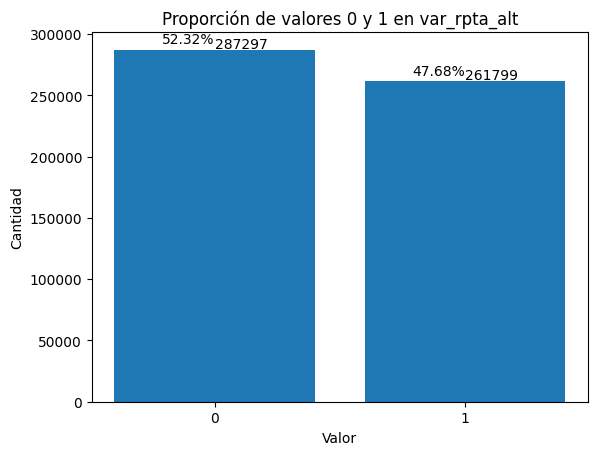

In [21]:
import matplotlib.pyplot as plt

# Obtener la cuenta de los valores 1 y 0 en la variable var_rpta_alt
counts = df_var_rpta_ppal_feature['var_rpta_alt'].value_counts()

# Calcular el porcentaje de cada valor
percentage_0 = counts[0] / len(df_var_rpta_ppal_feature) * 100
percentage_1 = counts[1] / len(df_var_rpta_ppal_feature) * 100

# Crear una figura y un eje
fig, ax = plt.subplots()

# Crear una lista de etiquetas para el gráfico
labels = ['0', '1']

# Crear una lista de valores para el gráfico
values = [counts[0], counts[1]]

# Crear un gráfico de barras
ax.bar(labels, values)

# Agregar etiquetas a las barras
for i, v in enumerate(values):
    ax.text(i, v + 1000, str(v), ha='left')

# Agregar título y etiquetas de los ejes
ax.set_title('Proporción de valores 0 y 1 en var_rpta_alt')
ax.set_xlabel('Valor')
ax.set_ylabel('Cantidad')

# Mostrar el porcentaje en el gráfico
ax.text(0, counts[0] + 5000, f'{percentage_0:.2f}%', ha='right')
ax.text(1, counts[1] + 5000, f'{percentage_1:.2f}%', ha='right')

# Mostrar el gráfico
plt.show()

La distribución de las clases es aproximadamente igual, siendo la clase uno 2% menor.
Revisemos como se distribuye los tipos de opciones de pago con respecto a esta variable.

Tipo de variable respuesta
* a_uno_tipo_1: acepta y aplica alternativa
* b_uno_tipo_2: acepta pero no se aplica
* c_uno_tipo_3: interesado mas no acepta (e)
* d_cero_tipo_1: ofrece pero no acepta
* e_cero_tipo_2: no sabemos si le ofrecen alternativa

In [22]:
import pandas as pd

# Crear un DataFrame con las columnas "tipo_var_rpta_alt" y "var_rpta_alt"
df = pd.DataFrame({'tipo_var_rpta_alt': df_var_rpta_ppal_feature['tipo_var_rpta_alt'],
                   'var_rpta_alt': df_var_rpta_ppal_feature['var_rpta_alt']})

# Calcular la distribución de tipo_var_rpta_alt con respecto a var_rpta_alt
distribution = df.groupby(['var_rpta_alt', 'tipo_var_rpta_alt']).size().unstack()

# Mostrar la distribución
# print(distribution)
distribution

tipo_var_rpta_alt,a_uno_tipo_1,b_uno_tipo_2,c_uno_tipo_3,d_cero_tipo_1,e_cero_tipo_2
var_rpta_alt,,,,,
0,NaN,NaN,NaN,16918.0,270379.0
1,173101.0,69545.0,19153.0,NaN,NaN


Revisando los tipos de uno y ceros se puede concluir lo siguiente:

Unos: 
  1. La mayoria de la población se encuentra entre entre la muestra "acepta y aplica alternativa" , lo cual seria el tipo más tangible/real.
  2. La muestra tipo 2 no es muy clara en su descripción del por qué no se aplica, pero al aceptar ya es un Uno tangible
  3. La muestra tipo 3 es la más pequeña proporcionalmente en grupo de unos, el interes no es tan tangible como el grupo 1, puede generar ruido.

Ceros:
  1. La muestra tipo 1 es la más pequeña proporcionalmente en grupo de ceros, la decisión de no aceptar es clara.
  2. La muestra tipo 2 es la más grande proporcionalmente en grupo de ceros, al no tener información clara, seria realizar un supuesto de que no se acepta por falta de información. puede generar ruido



In [23]:
df_var_rpta_ppal_feature.banca.value_counts()

Banca Personas    476374
Independientes     54499
Banca Pyme         18220
Empresas               3
Name: banca, dtype: int64

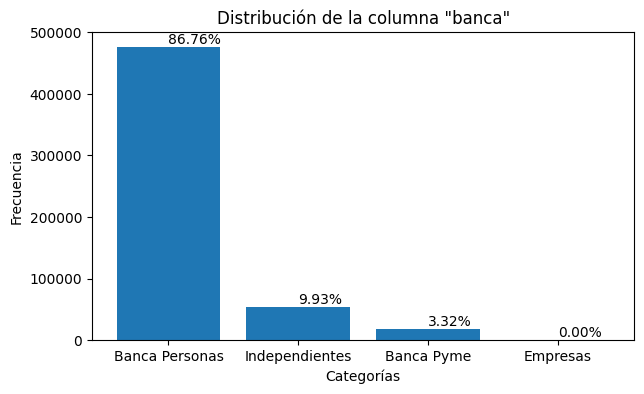

In [24]:
import matplotlib.pyplot as plt

# Obtener los valores de conteo
value_counts = df_var_rpta_ppal_feature.banca.value_counts()

# Calcular los porcentajes
percentages = (value_counts / value_counts.sum()) * 100

# Crear el gráfico de barras
plt.figure(figsize=(7, 4))
bars = plt.bar(value_counts.index, value_counts)

# Añadir etiquetas de porcentaje a cada barra
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}%', va='bottom')  # va='bottom' para colocar el texto justo encima de la barra

plt.title('Distribución de la columna "banca"')
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.show()

el 86.71% de la población se encuentra en la banca personas.

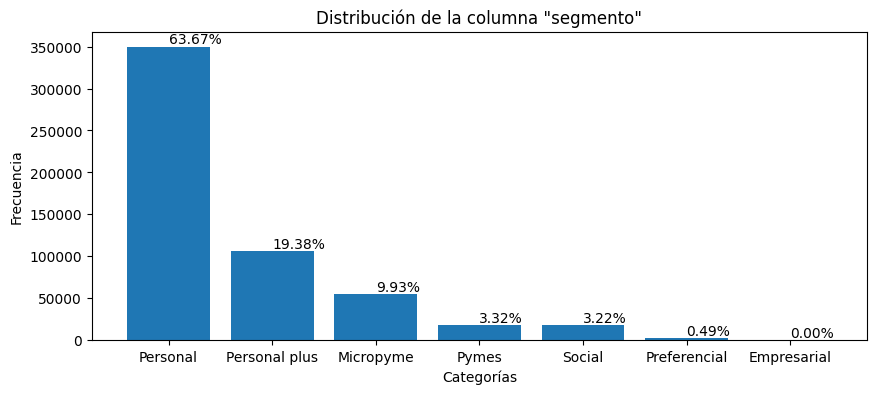

In [25]:
# Obtener los valores de conteo
value_counts = df_var_rpta_ppal_feature.segmento.value_counts()

# Calcular los porcentajes
percentages = (value_counts / value_counts.sum()) * 100

# Crear el gráfico de barras
plt.figure(figsize=(10, 4))
bars = plt.bar(value_counts.index, value_counts)

# Añadir etiquetas de porcentaje a cada barra
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.2f}%', va='bottom')  # va='bottom' para colocar el texto justo encima de la barra

plt.title('Distribución de la columna "segmento"')
plt.xlabel('Categorías')
plt.ylabel('Frecuencia')
plt.show()

Entre los segmentos persona y plus, esta el 80% de la población

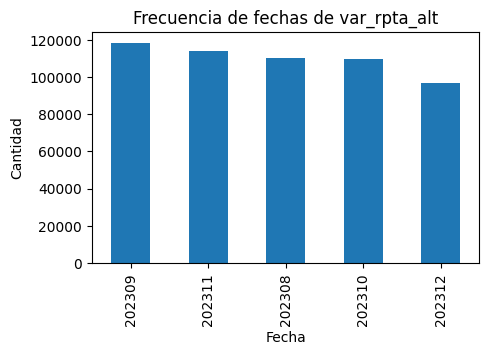

In [26]:
df_var_rpta_ppal_feature.fecha_var_rpta_alt.value_counts()
import matplotlib.pyplot as plt

counts = df_var_rpta_ppal_feature.fecha_var_rpta_alt.value_counts()

plt.figure(figsize=(5, 3))
counts.plot(kind='bar')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.title('Frecuencia de fechas de var_rpta_alt')
plt.show()

### Análisis de Poblaciones

#### Clase 1

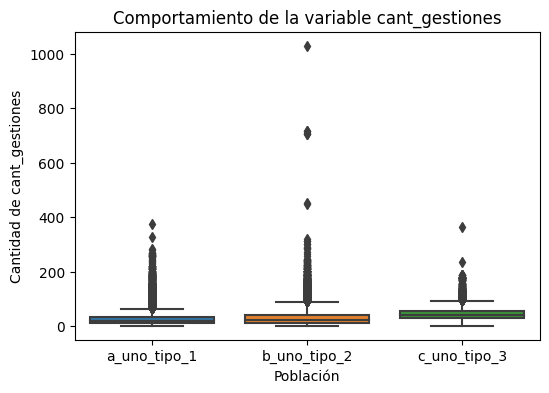

In [27]:
plot_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['a_uno_tipo_1', 'b_uno_tipo_2','c_uno_tipo_3'], 'tipo_var_rpta_alt', 'cant_gestiones')

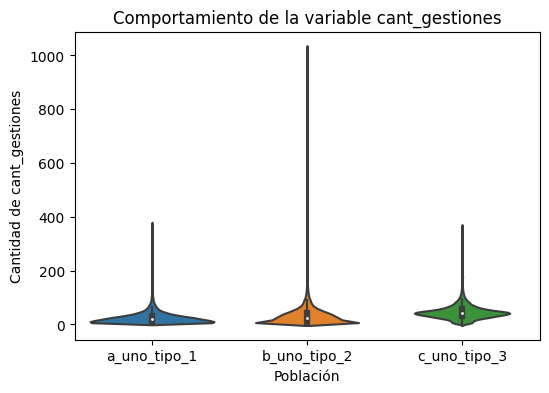

In [28]:
plot_violin_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['a_uno_tipo_1', 'b_uno_tipo_2','c_uno_tipo_3'], 'tipo_var_rpta_alt', 'cant_gestiones')

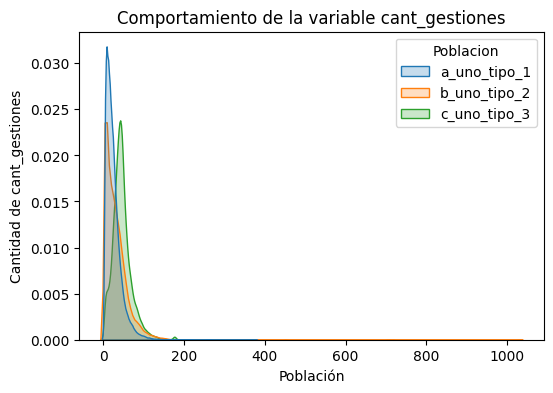

In [29]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['a_uno_tipo_1', 'b_uno_tipo_2','c_uno_tipo_3'], 'tipo_var_rpta_alt', 'cant_gestiones')

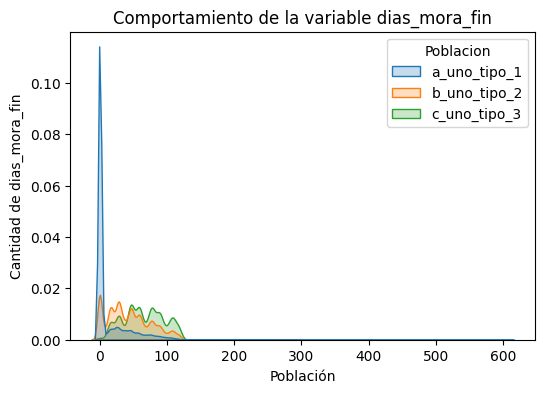

In [52]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['a_uno_tipo_1', 'b_uno_tipo_2','c_uno_tipo_3'], 'tipo_var_rpta_alt', 'dias_mora_fin')

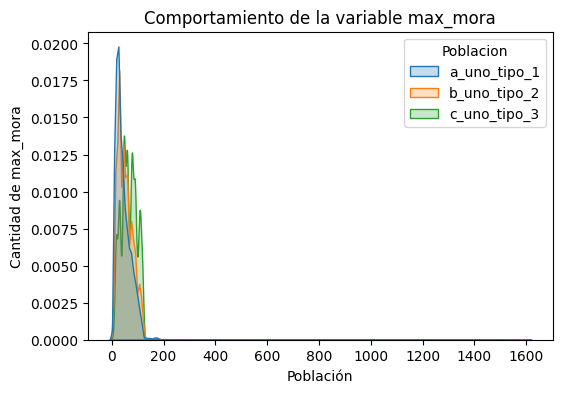

In [53]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['a_uno_tipo_1', 'b_uno_tipo_2','c_uno_tipo_3'], 'tipo_var_rpta_alt', 'max_mora')

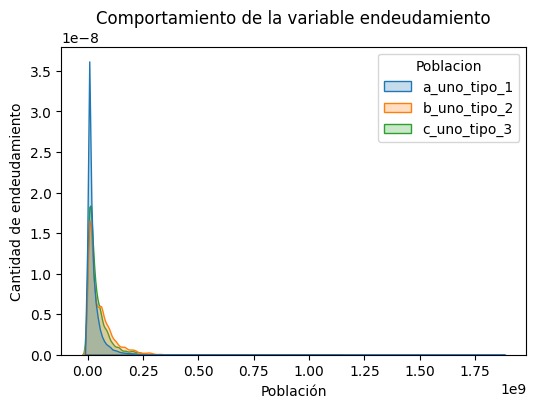

In [54]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['a_uno_tipo_1', 'b_uno_tipo_2','c_uno_tipo_3'], 'tipo_var_rpta_alt', 'endeudamiento')

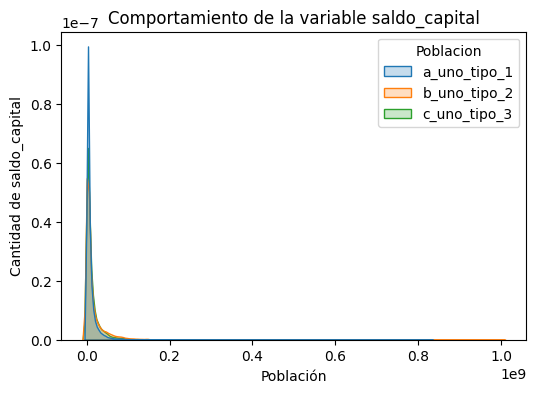

In [55]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['a_uno_tipo_1', 'b_uno_tipo_2','c_uno_tipo_3'], 'tipo_var_rpta_alt', 'saldo_capital')

In [37]:
variables = [
    'max_mora', 'dias_mora_fin', 'vlr_vencido', 'saldo_capital', 'endeudamiento',
    'cant_alter_posibles', 'cant_gestiones', 'cant_gestiones_binario', 'rpc', 
    'promesas_cumplidas', 'cant_promesas_cumplidas_binario', 'cant_acuerdo', 
    'cant_acuerdo_binario', 'valor_cuota_mes', 'pago_cuota', 'porc_pago_cuota', 'pago_mes',"tipo_var_rpta_alt"
]
df_var_interes=df_var_rpta_ppal_feature[variables]


In [38]:
df_var_interes_clase_1 = df_var_interes[df_var_interes['tipo_var_rpta_alt'].isin(['a_uno_tipo_1', 'b_uno_tipo_2','c_uno_tipo_3'])]


(261799, 18)

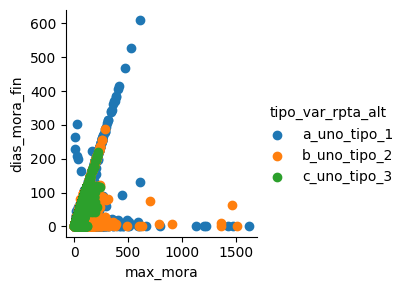

In [51]:
sns.FacetGrid(df_var_interes_clase_1, hue="tipo_var_rpta_alt") \
   .map(plt.scatter, "max_mora", "dias_mora_fin") \
   .add_legend()

In [ ]:
g = sns.lmplot(x="dias_mora_fin",
               y="max_mora",
               hue="tipo_var_rpta_alt",
               height=7,
               data=df_var_interes_clase_1)
g.set_xlabels('dias_mora_fin')
g.set_ylabels('max_mora')

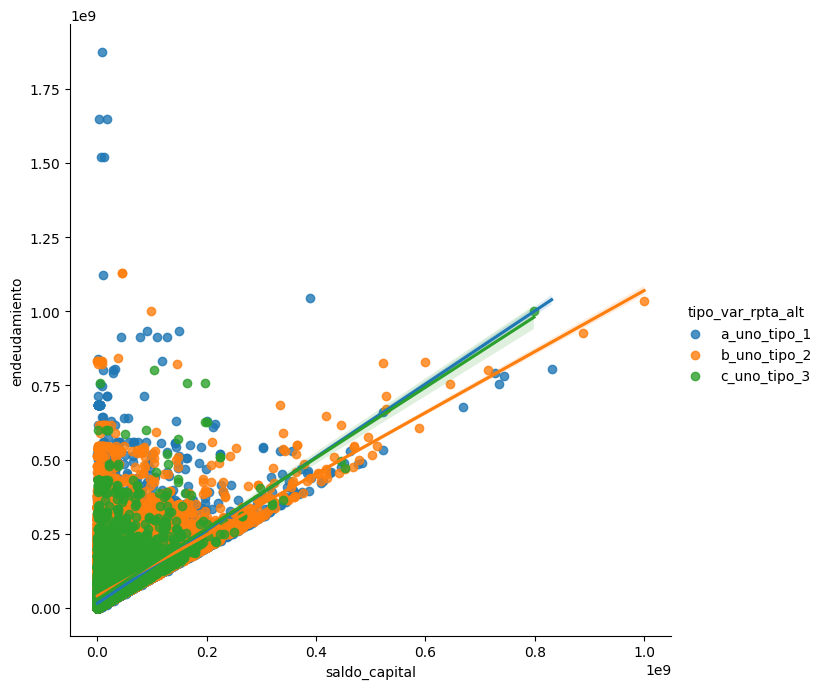

In [72]:
g = sns.lmplot(x="saldo_capital",
               y="endeudamiento",
               hue="tipo_var_rpta_alt",
               height=7,
               data=df_var_interes_clase_1)
g.set_xlabels('saldo_capital')
g.set_ylabels('endeudamiento')

In [268]:
from scipy.stats import mannwhitneyu

# Filtrar las poblaciones
unos_tipo1 = df_var_rpta_ppal_feature[df_var_rpta_ppal_feature['tipo_var_rpta_alt'] == 'a_uno_tipo_1']['endeudamiento']
ceros_tipo1 = df_var_rpta_ppal_feature[df_var_rpta_ppal_feature['tipo_var_rpta_alt'] == 'b_uno_tipo_2']['endeudamiento']

# Realizar la prueba U de Mann-Whitney
u_stat, p_value = mannwhitneyu(unos_tipo1, ceros_tipo1)

print(f'Estadístico U: {u_stat}')
print(f'Valor p: {p_value}')

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("Las poblaciones son significativamente diferentes.")
else:
    print("No hay evidencia suficiente para decir que las poblaciones son diferentes.")

Estadístico U: 3842290872.0
Valor p: 0.0
Las poblaciones son significativamente diferentes.


In [269]:
from scipy.stats import ttest_ind

unos_tipo1=df_var_rpta_ppal_feature[df_var_rpta_ppal_feature['tipo_var_rpta_alt']=='a_uno_tipo_1']['endeudamiento']
ceros_tipo1=df_var_rpta_ppal_feature[df_var_rpta_ppal_feature['tipo_var_rpta_alt']=='b_uno_tipo_2']['endeudamiento']

t_stat, p_value = ttest_ind(unos_tipo1, ceros_tipo1)

print(f'Estadístico t: {t_stat}')
print(f'Valor p: {p_value}')

# Interpretación del valor p
alpha = 0.05
if p_value < alpha:
    print("Las poblaciones son significativamente diferentes.")
else:
    print("No hay evidencia suficiente para decir que las poblaciones son diferentes.")

Estadístico t: -126.48216720825059
Valor p: 0.0
Las poblaciones son significativamente diferentes.


Clase 0

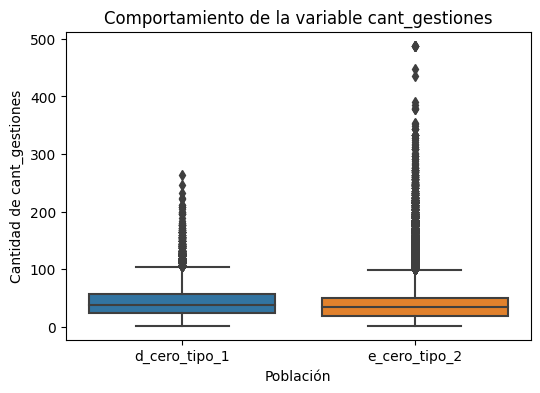

In [56]:
plot_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['d_cero_tipo_1', 'e_cero_tipo_2'], 'tipo_var_rpta_alt', 'cant_gestiones')

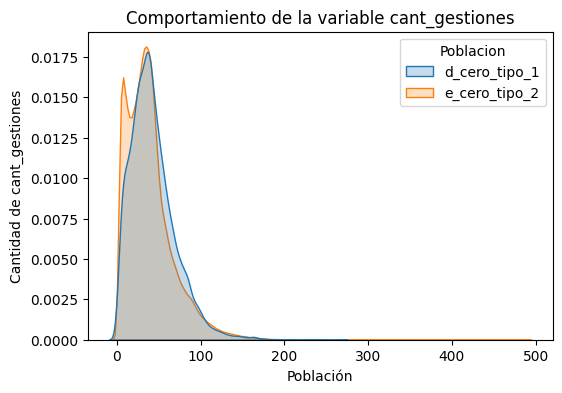

In [57]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['d_cero_tipo_1', 'e_cero_tipo_2'], 'tipo_var_rpta_alt', 'cant_gestiones')

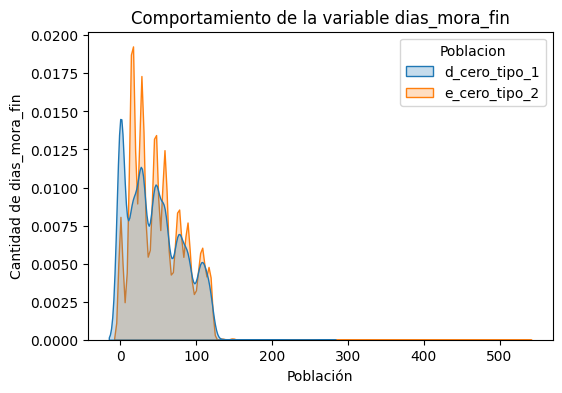

In [58]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['d_cero_tipo_1', 'e_cero_tipo_2'], 'tipo_var_rpta_alt', 'dias_mora_fin')

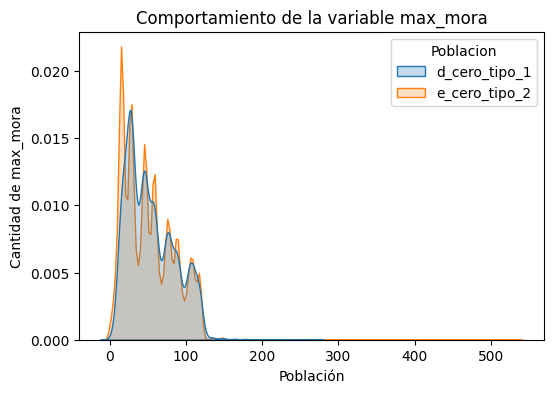

In [59]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['d_cero_tipo_1', 'e_cero_tipo_2'], 'tipo_var_rpta_alt', 'max_mora')

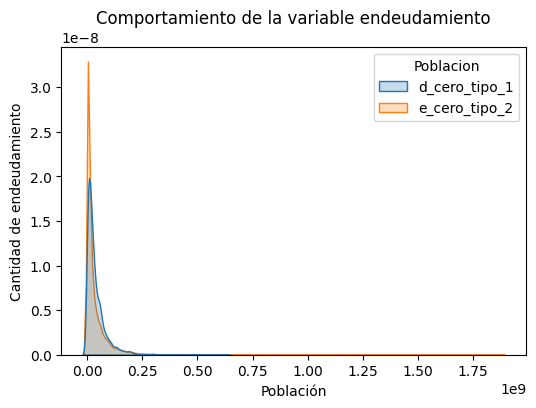

In [60]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['d_cero_tipo_1', 'e_cero_tipo_2'], 'tipo_var_rpta_alt', 'endeudamiento')

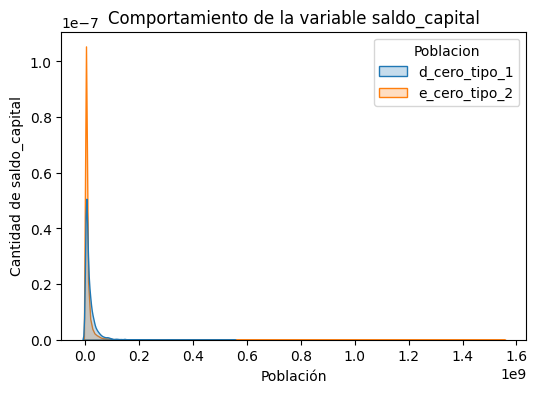

In [61]:
plot_densidad_vs_poblaciones_variable(df_var_rpta_ppal_feature, ['d_cero_tipo_1', 'e_cero_tipo_2'], 'tipo_var_rpta_alt', 'saldo_capital')

In [62]:
df_var_interes_clase_0 = df_var_interes[df_var_interes['tipo_var_rpta_alt'].isin(['d_cero_tipo_1', 'e_cero_tipo_2'])]

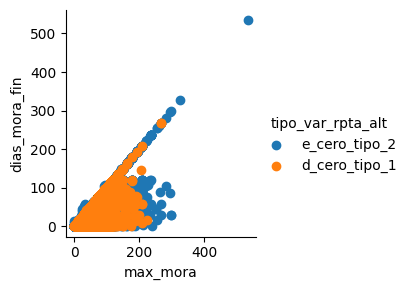

In [63]:
sns.FacetGrid(df_var_interes_clase_0, hue="tipo_var_rpta_alt") \
   .map(plt.scatter, "max_mora", "dias_mora_fin") \
   .add_legend()

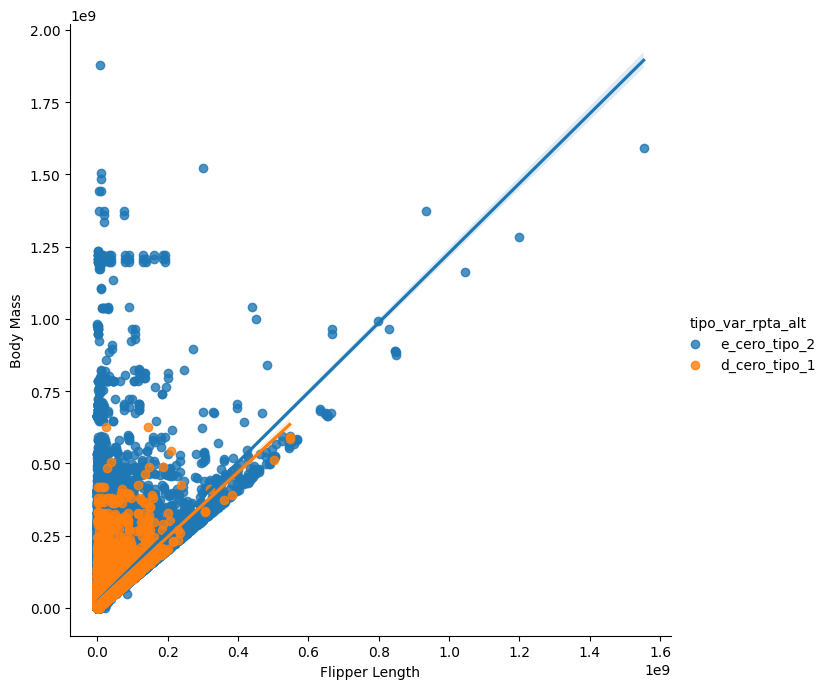

In [71]:
g = sns.lmplot(x="saldo_capital",
               y="endeudamiento",
               hue="tipo_var_rpta_alt",
               height=7,
               data=df_var_interes_clase_0)
g.set_xlabels('saldo_capital')
g.set_ylabels('endeudamiento')

UMAP Clase 0

In [105]:
op_data = df_var_interes_clase_0[
    [
    'max_mora',
    'dias_mora_fin',
    'vlr_vencido',
    'saldo_capital',
    'endeudamiento',
    'cant_alter_posibles',
    'cant_gestiones',
    'cant_gestiones_binario',
    'rpc',
    'promesas_cumplidas',
    'cant_promesas_cumplidas_binario',
    'cant_acuerdo',
    'cant_acuerdo_binario',
    'valor_cuota_mes',
    'pago_cuota',
    'porc_pago_cuota',
    'pago_mes'
]
].values
scaled_op_data = StandardScaler().fit_transform(op_data)

In [106]:
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
reducer = umap.UMAP()
embedding_clase0 = reducer.fit_transform(scaled_op_data)
embedding_clase0.shape

(287297, 2)

In [104]:
df_var_interes_clase_0.shape

(287297, 18)

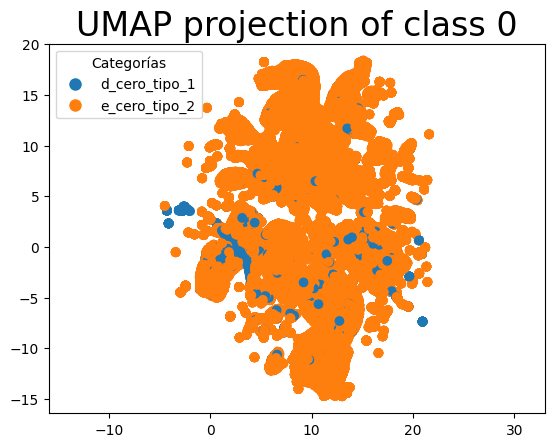

In [109]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir el mapeo de categorías a índices
category_mapping = {"d_cero_tipo_1": 0, "e_cero_tipo_2": 1}

# Obtener los colores para cada categoría
colors = [sns.color_palette()[x] for x in df_var_interes_clase_0.tipo_var_rpta_alt.map(category_mapping)]

# Crear el scatter plot
plt.scatter(embedding_clase0[:, 0], embedding_clase0[:, 1], c=colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of class 0', fontsize=24)

# Crear la leyenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sns.color_palette()[i], markersize=10) for i in range(len(category_mapping))]
labels = list(category_mapping.keys())
plt.legend(handles, labels, title="Categorías")

# Mostrar el gráfico
plt.show()

UMAP Clase 1

In [111]:
op_data = df_var_interes[
    [
    'max_mora',
    'dias_mora_fin',
    'vlr_vencido',
    'saldo_capital',
    'endeudamiento',
    'cant_alter_posibles',
    'cant_gestiones',
    'cant_gestiones_binario',
    'rpc',
    'promesas_cumplidas',
    'cant_promesas_cumplidas_binario',
    'cant_acuerdo',
    'cant_acuerdo_binario',
    'valor_cuota_mes',
    'pago_cuota',
    'porc_pago_cuota',
    'pago_mes'
]
].values
scaled_op_data = StandardScaler().fit_transform(op_data)

In [95]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_op_data)
embedding.shape

(261799, 2)

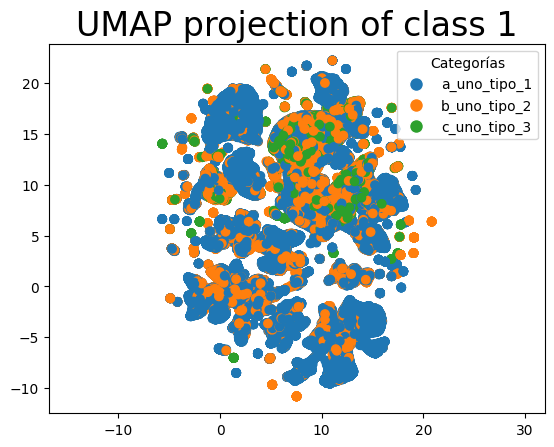

In [98]:
# Definir el mapeo de categorías a índices
category_mapping = {"a_uno_tipo_1": 0, "b_uno_tipo_2": 1, "c_uno_tipo_3": 2}

# Obtener los colores para cada categoría
colors = [sns.color_palette()[x] for x in df_var_interes_clase_1.tipo_var_rpta_alt.map(category_mapping)]

# Crear el scatter plot
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of class 1', fontsize=24)

# Crear la leyenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sns.color_palette()[i], markersize=10) for i in range(len(category_mapping))]
labels = list(category_mapping.keys())
plt.legend(handles, labels, title="Categorías")

# Mostrar el gráfico
plt.show()

UMAP para todas las clases

In [112]:
op_data = df_var_interes[
    [
    'max_mora',
    'dias_mora_fin',
    'vlr_vencido',
    'saldo_capital',
    'endeudamiento',
    'cant_alter_posibles',
    'cant_gestiones',
    'cant_gestiones_binario',
    'rpc',
    'promesas_cumplidas',
    'cant_promesas_cumplidas_binario',
    'cant_acuerdo',
    'cant_acuerdo_binario',
    'valor_cuota_mes',
    'pago_cuota',
    'porc_pago_cuota',
    'pago_mes'
]
].values
scaled_op_data = StandardScaler().fit_transform(op_data)

reducer = umap.UMAP()
embedding_all = reducer.fit_transform(scaled_op_data)
embedding_all.shape

(549096, 2)

c:\Users\davzapat\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


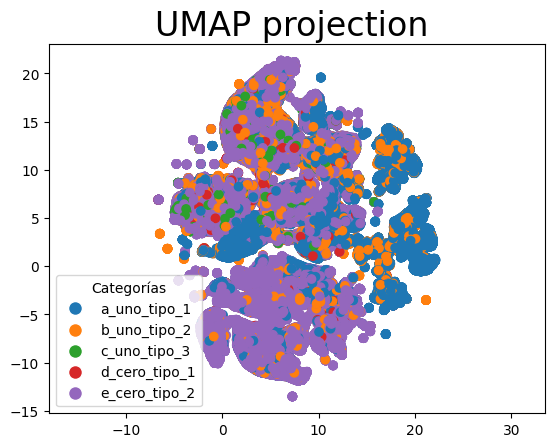

In [115]:
# Definir el mapeo de categorías a índices
category_mapping = {"a_uno_tipo_1": 0, "b_uno_tipo_2": 1, "c_uno_tipo_3": 2,"d_cero_tipo_1": 3, "e_cero_tipo_2": 4}

# Obtener los colores para cada categoría
colors = [sns.color_palette()[x] for x in df_var_interes.tipo_var_rpta_alt.map(category_mapping)]

# Crear el scatter plot
plt.scatter(embedding_all[:, 0], embedding_all[:, 1], c=colors)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection ', fontsize=24)

# Crear la leyenda
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=sns.color_palette()[i], markersize=10) for i in range(len(category_mapping))]
labels = list(category_mapping.keys())
plt.legend(handles, labels, title="Categorías")

# Mostrar el gráfico
plt.show()

Tabla Final

In [11]:
df_op_base_pivot_var_rpta_v1 = df_var_rpta_ppal_feature[[
    'llave_modelo'
    ,'llave_modelo_2'
    ,'fecha_var_rpta_alt'
    ,'var_rpta_alt'
    ,'tipo_var_rpta_alt'
    ,'banca'
    ,'segmento'
    ,'producto'
    ,'producto_cons'
    ,'min_mora'
    ,'max_mora'
    , 'dias_mora_fin'
    ,'vlr_vencido'
    ,'saldo_capital'
    ,'endeudamiento'
    , 'cant_gestiones'
    , 'cant_gestiones_binario'
    , 'rpc'
    , 'promesas_cumplidas'
    , 'cant_promesas_cumplidas_binario'
    , 'cant_acuerdo'
    , 'cant_acuerdo_binario'
    , 'descripcion_ranking_mejor_ult'
    , 'descripcion_ranking_post_ult'
    , 'marca_alt_rank'
    , 'marca_alt_apli'
    , 'valor_cuota_mes'
    , 'pago_cuota'
    , 'porc_pago_cuota'
    , 'pago_mes'
    , 'pagos_tanque'
]]

df_op_base_pivot_var_rpta_v1.shape

(549096, 31)

In [25]:
df_op_base_pivot_var_rpta_v1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 549096 entries, 0 to 568250
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   llave_modelo                     549096 non-null  object 
 1   fecha_var_rpta_alt               549096 non-null  int64  
 2   var_rpta_alt                     549096 non-null  int64  
 3   tipo_var_rpta_alt                549096 non-null  object 
 4   banca                            549096 non-null  object 
 5   segmento                         549096 non-null  object 
 6   producto                         549096 non-null  object 
 7   producto_cons                    549096 non-null  object 
 8   min_mora                         549096 non-null  int64  
 9   max_mora                         549096 non-null  int64  
 10  dias_mora_fin                    549096 non-null  int64  
 11  vlr_vencido                      549096 non-null  float64
 12  sa

In [13]:
df_op_base_pivot_var_rpta_v1['producto'].value_counts()

TARJETA DE CREDITO      232496
LIBRE INVERSION         197781
ROTATIVOS                77944
CARTERA ORDINARIA        11777
HIPOTECARIO VIVIENDA     10083
LIBRANZA                  9814
CARTERA MICROCREDITO      5689
CREDIPAGO                 1377
SOBREGIRO                 1289
LEASING HABITACIONAL       639
TESORERIA                  134
Titularizada                34
LEASING                     23
OTROS HIPOTECARIO           12
TARJETAS DE CREDITO          4
Name: producto, dtype: int64

In [21]:
grouped_counts = df_op_base_pivot_var_rpta_v1.groupby('tipo_var_rpta_alt')['producto'].value_counts()

grouped_counts_df = grouped_counts.reset_index(name='counts')

pd.set_option('display.max_rows', None)
grouped_counts_df

,tipo_var_rpta_alt,producto,counts
0,a_uno_tipo_1,TARJETA DE CREDITO,95720
1,a_uno_tipo_1,LIBRE INVERSION,55560
2,a_uno_tipo_1,ROTATIVOS,15818
3,a_uno_tipo_1,HIPOTECARIO VIVIENDA,1936
4,a_uno_tipo_1,CARTERA MICROCREDITO,1672
5,a_uno_tipo_1,LIBRANZA,1497
6,a_uno_tipo_1,CARTERA ORDINARIA,757
7,a_uno_tipo_1,CREDIPAGO,94
8,a_uno_tipo_1,SOBREGIRO,31
9,a_uno_tipo_1,TESORERIA,11


In [12]:
productos = {
    'TARJETA DE CREDITO': 'tiene_tdc',
    'LIBRE INVERSION': 'tiene_libr_inv',
    'CARTERA ORDINARIA': 'tiene_cart_ordinaria',
    'HIPOTECARIO VIVIENDA': 'tiene_hipo',
    'LIBRANZA': 'tiene_libranza',
    'ROTATIVOS' : 'tiene_rot'
}

for producto, columna in productos.items():
    df_op_base_pivot_var_rpta_v1[columna] = (df_op_base_pivot_var_rpta_v1['producto'] == producto).astype(int)

df_op_base_pivot_var_rpta_v1['tiene_otros_productos'] = (~df_op_base_pivot_var_rpta_v1['producto'].isin(productos.keys())).astype(int)


C:\Users\davzapat\AppData\Local\Temp\ipykernel_3332\3897657522.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_op_base_pivot_var_rpta_v1[columna] = (df_op_base_pivot_var_rpta_v1['producto'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_3332\3897657522.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_op_base_pivot_var_rpta_v1[columna] = (df_op_base_pivot_var_rpta_v1['producto'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_3332\3897657522.py:

In [30]:
df_op_base_pivot_var_rpta_v1['descripcion_ranking_mejor_ult'].value_counts()

PLAN DE PAGO                          187496
ACEPTA ALTERNATIVA                    154072
NO ACEPTA ACUERDO                     126466
PLAN DE COMPROMISO CUMPLIDO            34156
INTERESADO ALTERNATIVA                 20661
NO ACEPTA ALTERNATIVA                  10222
MANIFIESTA YA PAGO                      8303
NO CONTESTA                             3870
MENSAJE INFORMATIVO - SIN CONTACTO      1825
NO RECIBE INFORMACION                    845
APROBADA NEGOCIACION COBRANZAS           343
GESTION MAQUINA                          244
ACEPTA ACUERDO COBRANZAS                 236
ILOCALIZADO                              215
CONTACTO WHATSTAPP                       108
SIN ALTERNATIVA                           27
NO APLICA                                  2
ACEPTA ALTERNATIVA SEGUIMIENTO             2
FRAUDE                                     1
ESTUDIO COBRANZAS                          1
CLIENTE AL DIA                             1
Name: descripcion_ranking_mejor_ult, dtype: int64

In [13]:
descripcion_ranking_mejor_ult = {
    'PLAN DE PAGO ': 'ranking_plan_pago',
    'ACEPTA ALTERNATIVA': 'ranking_acepta_alternativa',
    'NO ACEPTA ACUERDO': 'ranking_no_acepta_acuerdo',
    'PLAN DE COMPROMISO CUMPLIDO': 'ranking_plan_compromiso_cumplido',
    'INTERESADO ALTERNATIVA': 'ranking_int_alternativa'
}

for descripcion, columna in descripcion_ranking_mejor_ult.items():
    df_op_base_pivot_var_rpta_v1[columna] = (df_op_base_pivot_var_rpta_v1['descripcion_ranking_mejor_ult'] == descripcion).astype(int)

df_op_base_pivot_var_rpta_v1['ranking_otros'] = (~df_op_base_pivot_var_rpta_v1['descripcion_ranking_mejor_ult'].isin(descripcion_ranking_mejor_ult.keys())).astype(int)

C:\Users\davzapat\AppData\Local\Temp\ipykernel_3332\2649238623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_op_base_pivot_var_rpta_v1[columna] = (df_op_base_pivot_var_rpta_v1['descripcion_ranking_mejor_ult'] == descripcion).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_3332\2649238623.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_op_base_pivot_var_rpta_v1[columna] = (df_op_base_pivot_var_rpta_v1['descripcion_ranking_mejor_ult'] == descripcion).astype(int)
C:\Users\davzapat\

In [14]:
# Filtrar el DataFrame
df_op_base_pivot_var_rpta_v1_filtered = df_op_base_pivot_var_rpta_v1[
    (df_op_base_pivot_var_rpta_v1['tipo_var_rpta_alt'].isin(['a_uno_tipo_1', 'b_uno_tipo_2', 'd_cero_tipo_1'])) &
    (df_op_base_pivot_var_rpta_v1['banca'] == 'Banca Personas')
]

# Mostrar el DataFrame filtrado
df_op_base_pivot_var_rpta_v1_filtered.shape

(234002, 44)

In [15]:
df_op_base_pivot_var_rpta_v1_filtered['pagos_tanque'] = df_op_base_pivot_var_rpta_v1_filtered['pagos_tanque'].replace({'Sin pago': 0, 'Con pago': 1})

C:\Users\davzapat\AppData\Local\Temp\ipykernel_3332\2036505893.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_op_base_pivot_var_rpta_v1_filtered['pagos_tanque'] = df_op_base_pivot_var_rpta_v1_filtered['pagos_tanque'].replace({'Sin pago': 0, 'Con pago': 1})


In [16]:
df_op_base_pivot_var_rpta_v2=df_op_base_pivot_var_rpta_v1_filtered.drop(['producto','banca',
                            'segmento',
                            'producto_cons','descripcion_ranking_mejor_ult',
                            'descripcion_ranking_post_ult','marca_alt_rank','marca_alt_apli'], axis=1)
df_op_base_pivot_var_rpta_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 234002 entries, 0 to 568239
Data columns (total 36 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   llave_modelo                      234002 non-null  object 
 1   llave_modelo_2                    234002 non-null  object 
 2   fecha_var_rpta_alt                234002 non-null  int64  
 3   var_rpta_alt                      234002 non-null  int64  
 4   tipo_var_rpta_alt                 234002 non-null  object 
 5   min_mora                          234002 non-null  int64  
 6   max_mora                          234002 non-null  int64  
 7   dias_mora_fin                     234002 non-null  int64  
 8   vlr_vencido                       234002 non-null  float64
 9   saldo_capital                     234002 non-null  float64
 10  endeudamiento                     234002 non-null  float64
 11  cant_gestiones                    234002 non-null  i

In [49]:
df_op_base_pivot_var_rpta_v2['fecha_corte']=df_op_base_pivot_var_rpta_v2['fecha_var_rpta_alt']-1

In [50]:
df_op_base_pivot_var_rpta_v2.head()

,llave_modelo,llave_modelo_2,fecha_var_rpta_alt,var_rpta_alt,tipo_var_rpta_alt,min_mora,max_mora,dias_mora_fin,vlr_vencido,saldo_capital,...,tiene_libranza,tiene_rot,tiene_otros_productos,ranking_plan_pago,ranking_acepta_alternativa,ranking_no_acepta_acuerdo,ranking_plan_compromiso_cumplido,ranking_int_alternativa,ranking_otros,fecha_corte
0,630611#219718#863073,630611#219718,202308,1,a_uno_tipo_1,46,71,71,1000259.0,5808115.68,...,0,0,0,0,1,0,0,0,0,202307
1,59412#789567#290775,59412#789567,202312,1,a_uno_tipo_1,16,24,0,443638.0,9451816.00,...,0,0,0,0,1,0,0,0,0,202311
2,277595#1045909#34433,277595#1045909,202312,1,b_uno_tipo_2,36,65,65,7650063.0,75144222.95,...,0,0,0,0,0,0,1,0,0,202311
3,26897#585786#494556,26897#585786,202311,1,a_uno_tipo_1,18,40,0,266898.0,3785620.00,...,0,1,0,0,0,0,0,0,1,202310
4,24588#1061389#18953,24588#1061389,202311,1,b_uno_tipo_2,18,32,32,43471.0,787131.00,...,0,1,0,0,1,0,0,0,0,202310


In [51]:
df_op_base_pivot_var_rpta_v2.to_csv('df_op_base_pivot_var_rpta_v2.csv', index=False)

## prueba_op_probabilidad_oblig_base_hist_enmascarado_completa

In [57]:
df_var_prob_mod_cobranza = pd.read_csv('prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv')
df_var_prob_mod_cobranza.head(5)


C:\Users\davzapat\AppData\Local\Temp\ipykernel_3332\1523551295.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_var_prob_mod_cobranza = pd.read_csv('prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv')


,nit_enmascarado,num_oblig_enmascarado,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura
0,296482,102381,202308,1,0.761350,0.193744,0.684784
1,391957,742315,202310,2,0.741803,0.384184,0.483696
2,229894,359919,202307,1,0.835373,0.285157,0.826225
3,478963,239064,202303,3,0.445002,0.629652,0.346508
4,349609,923348,202308,2,0.784365,0.419123,0.667603


In [58]:
df_var_prob_mod_cobranza["llave_modelo_2"] = df_var_prob_mod_cobranza["nit_enmascarado"].astype(str) + \
                                                    "#" + df_var_prob_mod_cobranza["num_oblig_enmascarado"].astype(str) 

In [38]:
df_var_prob_mod_cobranza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4804836 entries, 0 to 4804835
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   nit_enmascarado        int64  
 1   num_oblig_enmascarado  int64  
 2   fecha_corte            int64  
 3   lote                   int64  
 4   prob_propension        float64
 5   prob_alrt_temprana     object 
 6   prob_auto_cura         object 
 7   llave_modelo_2         object 
dtypes: float64(1), int64(4), object(3)
memory usage: 293.3+ MB


In [59]:
df_var_prob_mod_cobranza['fecha_corte_format'] = pd.to_datetime(df_var_prob_mod_cobranza['fecha_corte'], format='%Y%m')
df_var_prob_mod_cobranza = df_var_prob_mod_cobranza.sort_values(by='fecha_corte_format')

In [60]:
reporte_features_nan=calidad_none(df_var_prob_mod_cobranza)

reporte_features_nan = reporte_features_nan.sort_values(by='None_Count', ascending=False)

In [61]:
reporte_features_nan

,Column,None_Count,None_Percentage
5,prob_alrt_temprana,7,0.000001
6,prob_auto_cura,7,0.000001
0,nit_enmascarado,0,0.000000
1,num_oblig_enmascarado,0,0.000000
2,fecha_corte,0,0.000000
3,lote,0,0.000000
4,prob_propension,0,0.000000
7,llave_modelo_2,0,0.000000
8,fecha_corte_format,0,0.000000


In [62]:
# Reemplazar 'None' (cadena) con NaN
df_var_prob_mod_cobranza = df_var_prob_mod_cobranza.replace('None', np.nan)
df_var_prob_mod_cobranza = df_var_prob_mod_cobranza.dropna()

In [66]:
df_var_prob_mod_cobranza = convertir_columnas_a_tipo(df_var_prob_mod_cobranza, 
                                                     ['prob_alrt_temprana','prob_auto_cura'],float)

In [67]:
revisar_atipicos(df_var_prob_mod_cobranza)

,Column,Outliers_Count,Outliers_Percentage
0,nit_enmascarado,0,0.000000
1,num_oblig_enmascarado,0,0.000000
2,fecha_corte,0,0.000000
3,lote,0,0.000000
4,prob_propension,409212,0.085167
5,prob_alrt_temprana,0,0.000000
6,prob_auto_cura,0,0.000000


In [68]:
# Lista de columnas para las cuales se generarán las variables autorregresivas
columns = ['lote', 'prob_propension', 'prob_alrt_temprana', 'prob_auto_cura']

# Generar variables autorregresivas hasta 6
for i in range(1, 7):
    for col in columns:
        df_var_prob_mod_cobranza[f'{col}_n-{i}'] = df_var_prob_mod_cobranza.groupby('llave_modelo_2')[col].shift(i)

# Mostrar el DataFrame modificado
df_var_prob_mod_cobranza

,nit_enmascarado,num_oblig_enmascarado,fecha_corte,lote,prob_propension,prob_alrt_temprana,prob_auto_cura,llave_modelo_2,fecha_corte_format,lote_n-1,...,prob_alrt_temprana_n-4,prob_auto_cura_n-4,lote_n-5,prob_propension_n-5,prob_alrt_temprana_n-5,prob_auto_cura_n-5,lote_n-6,prob_propension_n-6,prob_alrt_temprana_n-6,prob_auto_cura_n-6
815579,164776,19485,202301,1,0.720118,0.440000,0.271708,164776#19485,2023-01-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
914513,634546,719459,202301,1,0.839983,0.109204,0.848772,634546#719459,2023-01-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
293724,277245,114376,202301,1,0.950276,0.052306,0.765392,277245#114376,2023-01-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2306977,261698,937604,202301,1,0.771990,0.182177,0.664738,261698#937604,2023-01-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4230387,310745,407368,202301,2,0.699661,0.814249,0.713048,310745#407368,2023-01-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006236,10851,730411,202312,1,0.061945,0.566907,0.219653,10851#730411,2023-12-01,1.0,...,0.560855,0.133313,1.0,0.475092,0.562177,0.154973,1.0,0.725710,0.603775,0.225987
393000,502667,56423,202312,1,0.580920,0.430970,0.379501,502667#56423,2023-12-01,1.0,...,0.661023,0.253046,1.0,0.778096,0.580410,0.334014,1.0,0.927999,0.245988,0.779250
1819800,388020,733649,202312,1,0.832764,0.212436,0.488154,388020#733649,2023-12-01,1.0,...,0.394087,0.850825,1.0,0.833938,0.441487,0.864718,1.0,0.832412,0.367077,0.840322
392987,345193,596724,202312,2,0.318892,0.770792,0.103375,345193#596724,2023-12-01,2.0,...,0.727255,0.154023,2.0,0.309854,0.787085,0.123279,1.0,0.754906,0.735405,0.161590


In [69]:
df_var_prob_mod_cobranza.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4804829 entries, 815579 to 748982
Data columns (total 33 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   nit_enmascarado         int64         
 1   num_oblig_enmascarado   int64         
 2   fecha_corte             int64         
 3   lote                    int64         
 4   prob_propension         float64       
 5   prob_alrt_temprana      float64       
 6   prob_auto_cura          float64       
 7   llave_modelo_2          object        
 8   fecha_corte_format      datetime64[ns]
 9   lote_n-1                float64       
 10  prob_propension_n-1     float64       
 11  prob_alrt_temprana_n-1  float64       
 12  prob_auto_cura_n-1      float64       
 13  lote_n-2                float64       
 14  prob_propension_n-2     float64       
 15  prob_alrt_temprana_n-2  float64       
 16  prob_auto_cura_n-2      float64       
 17  lote_n-3                float64       
 18

In [70]:
df_var_prob_mod_cobranza_v2=df_var_prob_mod_cobranza[df_var_prob_mod_cobranza['fecha_corte']>=202307]

In [71]:
df_var_prob_mod_cobranza_v2['fecha_corte'].unique()

df_var_prob_mod_cobranza_v2.to_csv('df_var_prob_mod_cobranza_v2.csv', index=False)

In [72]:
df_var_prob_mod_cobranza_v2.shape

(2530714, 33)

## prueba_op_master_customer_data_enmascarado_completa

In [3]:
df_master_customer = pd.read_csv('prueba_op_master_customer_data_enmascarado_completa.csv')
df_master_customer.head()

C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\2904546747.py:1: DtypeWarning: Columns (17,18,19,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_master_customer = pd.read_csv('prueba_op_master_customer_data_enmascarado_completa.csv')


,nit_enmascarado,cod_tipo_doc,tipo_cli,ctrl_terc,genero_cli,ano_nac_cli,edad_cli,estado_civil,tipo_vivienda,num_hijos,...,nicho,region_of,nombre_dpto_dirp,egresos_mes,tot_patrimonio,ciiu,smmlv,year,month,ingestion_day
0,536377,1,PERSONA NATURAL,CLIENTE,F,1998,25,SOLTERO,FAMILIAR,0,...,MUJERES,CENTRO,SANTANDER,0.0,33750000.0,None,1160000.0,2023,12,31
1,512257,1,PERSONA NATURAL,CLIENTE,F,1984,38,UNION LIBRE,PROPIA,0,...,MUJERES,CARIBE,MAGDALENA,250000.0,5000000.0,ASALARIADOS,1160000.0,2023,9,30
2,5788,1,PERSONA NATURAL,CLIENTE SOCIAL,M,1960,63,None,None,0,...,None,DIRECCIÓN GENERAL,SIN INFORMACION,0.0,0.0,ASALARIADOS,1160000.0,2023,11,30
3,132245,1,PERSONA NATURAL,CLIENTE,F,1982,41,CASADO,None,1,...,MUJERES,SUR,VALLE,1000000.0,62513000.0,ASALARIADOS,1160000.0,2023,7,31
4,245279,1,PERSONA NATURAL,CLIENTE,M,1980,43,CASADO,ALQUILADA,0,...,None,BOGOTA Y CUNDINAMARCA,CALDAS,1000000.0,34135000.0,ASALARIADOS,1160000.0,2023,12,31


In [4]:
df_master_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430000 entries, 0 to 429999
Data columns (total 37 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   nit_enmascarado        430000 non-null  int64  
 1   cod_tipo_doc           430000 non-null  int64  
 2   tipo_cli               430000 non-null  object 
 3   ctrl_terc              430000 non-null  object 
 4   genero_cli             430000 non-null  object 
 5   ano_nac_cli            430000 non-null  object 
 6   edad_cli               430000 non-null  object 
 7   estado_civil           430000 non-null  object 
 8   tipo_vivienda          430000 non-null  object 
 9   num_hijos              430000 non-null  object 
 10  personas_dependientes  430000 non-null  object 
 11  nivel_academico        430000 non-null  object 
 12  ocup                   430000 non-null  object 
 13  act_econom             430000 non-null  object 
 14  sector                 430000 non-nu

In [6]:
df_master_customer_v1 = df_master_customer[[
    'nit_enmascarado'
    , 'ctrl_terc'
    , 'edad_cli'
    , 'estado_civil'
    , 'tipo_vivienda'
    , 'num_hijos'
    , 'personas_dependientes'
    , 'nivel_academico'
    , 'declarante'
    , 'total_ing'
    , 'tot_activos'
    , 'tot_pasivos'
    , 'egresos_mes'
    , 'tot_patrimonio'
    , 'year'
    , 'month'
]]

In [7]:
df_master_customer_v1.head()

,nit_enmascarado,ctrl_terc,edad_cli,estado_civil,tipo_vivienda,num_hijos,personas_dependientes,nivel_academico,declarante,total_ing,tot_activos,tot_pasivos,egresos_mes,tot_patrimonio,year,month
0,536377,CLIENTE,25,SOLTERO,FAMILIAR,0,0,UNIVERSITARIO,N,2607680.0,33750000.0,0.0,0.0,33750000.0,2023,12
1,512257,CLIENTE,38,UNION LIBRE,PROPIA,0,0,TECNOLOGO,N,1000000.0,5000000.0,0.0,250000.0,5000000.0,2023,9
2,5788,CLIENTE SOCIAL,63,None,None,0,0,None,N,0.0,0.0,0.0,0.0,0.0,2023,11
3,132245,CLIENTE,41,CASADO,None,1,0,TECNOLOGO,N,1800000.0,62513000.0,0.0,1000000.0,62513000.0,2023,7
4,245279,CLIENTE,43,CASADO,ALQUILADA,0,1,NO INFORMA,N,2500000.0,45135000.0,11000000.0,1000000.0,34135000.0,2023,12


In [8]:
df_master_customer_v1['ctrl_terc'].value_counts()



CLIENTE           410835
CLIENTE SOCIAL     17959
EXCLIENTE           1163
NEQUI                 32
PROSPECTO              6
CONYUGE                5
Name: ctrl_terc, dtype: int64

In [11]:
productos = {
    'CLIENTE': 'es_cliente',
    'CLIENTE SOCIAL': 'es_cliente_social',
    'EXCLIENTE': 'es_excliente'
}

for producto, columna in productos.items():
    df_master_customer_v1[columna] = (df_master_customer_v1['ctrl_terc'] == producto).astype(int)

C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\3303272307.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master_customer_v1[columna] = (df_master_customer_v1['ctrl_terc'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\3303272307.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master_customer_v1[columna] = (df_master_customer_v1['ctrl_terc'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\3303272307.py:8: SettingWithCopyWarning

In [9]:
df_master_customer_v1['estado_civil'].value_counts()

SOLTERO        187378
CASADO          81479
UNION LIBRE     74808
None            36474
NO INFORMA      32783
DIVORCIADO      10093
VIUDO            4997
OTRO             1988
Name: estado_civil, dtype: int64

In [14]:
productos = {
    'SOLTERO': 'es_soltero',
    'CASADO': 'es_casado',
    'UNION LIBRE': 'es_union_libre'
}

for producto, columna in productos.items():
    df_master_customer_v1[columna] = (df_master_customer_v1['estado_civil'] == producto).astype(int)

C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\4213962752.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master_customer_v1[columna] = (df_master_customer_v1['estado_civil'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\4213962752.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master_customer_v1[columna] = (df_master_customer_v1['estado_civil'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\4213962752.py:8: SettingWithCopyW

In [15]:
df_master_customer_v1['tipo_vivienda'].value_counts()

None          294877
FAMILIAR       71552
ALQUILADA      29080
PROPIA         26756
NO INFORMA      7735
Name: tipo_vivienda, dtype: int64

In [17]:
productos = {
    'FAMILIAR': 'vivienda_familiar',
    'PROPIA': 'vivienda_propia',
    'ALQUILADA': 'vivienda_alquilada',
}

for producto, columna in productos.items():
    df_master_customer_v1[columna] = (df_master_customer_v1['tipo_vivienda'] == producto).astype(int)

C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\4187771689.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master_customer_v1[columna] = (df_master_customer_v1['tipo_vivienda'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\4187771689.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master_customer_v1[columna] = (df_master_customer_v1['tipo_vivienda'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\4187771689.py:8: SettingWithCop

In [18]:
df_master_customer_v1['nivel_academico'].value_counts()

None               245002
UNIVERSITARIO       49049
NO INFORMA          44013
BACHILLER           42354
TECNOLOGO           33083
PRIMARIA             7615
ESPECIALIZACION      5734
NINGUNO              3150
Name: nivel_academico, dtype: int64

In [19]:
productos = {
    'UNIVERSITARIO': 'acad_universitario',
    'BACHILLER': 'acad_bachiller',
    'TECNOLOGO': 'acad_tecnologo',
    'PRIMARIA': 'acad_primaria',
    'ESPECIALIZACION': 'acad_especializacion'
}

for producto, columna in productos.items():
    df_master_customer_v1[columna] = (df_master_customer_v1['nivel_academico'] == producto).astype(int)

C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\2629084364.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master_customer_v1[columna] = (df_master_customer_v1['nivel_academico'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\2629084364.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master_customer_v1[columna] = (df_master_customer_v1['nivel_academico'] == producto).astype(int)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\2629084364.py:10: Setting

In [20]:
df_master_customer_v1['declarante'].value_counts()

N       394613
S        35209
None       178
Name: declarante, dtype: int64

In [21]:
df_master_customer_v1['declarante'].unique()

array(['N', 'S', 'None'], dtype=object)

In [22]:
df_master_customer_v1['declarante'] = df_master_customer_v1['declarante'].replace({'N': 0,'None':0, 'S': 1})

C:\Users\davzapat\AppData\Local\Temp\ipykernel_48516\3691332552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master_customer_v1['declarante'] = df_master_customer_v1['declarante'].replace({'N': 0,'None':0, 'S': 1})


In [25]:
df_master_customer_v1.head()

,nit_enmascarado,ctrl_terc,edad_cli,estado_civil,tipo_vivienda,num_hijos,personas_dependientes,nivel_academico,declarante,total_ing,...,es_casado,es_union_libre,vivienda_familiar,vivienda_propia,vivienda_alquilada,acad_universitario,acad_bachiller,acad_tecnologo,acad_primaria,acad_especializacion
0,536377,CLIENTE,25,SOLTERO,FAMILIAR,0,0,UNIVERSITARIO,0,2607680.0,...,0,0,1,0,0,1,0,0,0,0
1,512257,CLIENTE,38,UNION LIBRE,PROPIA,0,0,TECNOLOGO,0,1000000.0,...,0,1,0,1,0,0,0,1,0,0
2,5788,CLIENTE SOCIAL,63,None,None,0,0,None,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,132245,CLIENTE,41,CASADO,None,1,0,TECNOLOGO,0,1800000.0,...,1,0,0,0,0,0,0,1,0,0
4,245279,CLIENTE,43,CASADO,ALQUILADA,0,1,NO INFORMA,0,2500000.0,...,1,0,0,0,1,0,0,0,0,0


In [26]:
df_master_customer_v2 = df_master_customer_v1.drop(['ctrl_terc',
                                'estado_civil','tipo_vivienda','nivel_academico'], axis=1)

In [31]:
df_master_customer_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430000 entries, 0 to 429999
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   nit_enmascarado        430000 non-null  int64 
 1   edad_cli               430000 non-null  object
 2   num_hijos              430000 non-null  object
 3   personas_dependientes  430000 non-null  object
 4   declarante             430000 non-null  int64 
 5   total_ing              430000 non-null  object
 6   tot_activos            430000 non-null  object
 7   tot_pasivos            430000 non-null  object
 8   egresos_mes            430000 non-null  object
 9   tot_patrimonio         430000 non-null  object
 10  year                   430000 non-null  int64 
 11  month                  430000 non-null  int64 
 12  es_cliente             430000 non-null  int32 
 13  es_cliente_social      430000 non-null  int32 
 14  es_excliente           430000 non-null  int32 
 15  

In [28]:
calidad_none(df_master_customer_v2)

,Column,None_Count,None_Percentage
0,nit_enmascarado,0,0.000000
1,edad_cli,7942,0.018470
2,num_hijos,7942,0.018470
3,personas_dependientes,7945,0.018477
4,declarante,0,0.000000
5,total_ing,4,0.000009
6,tot_activos,4,0.000009
7,tot_pasivos,4,0.000009
8,egresos_mes,4,0.000009
9,tot_patrimonio,4,0.000009


In [32]:
df_master_customer_v2['edad_cli'] = pd.to_numeric(df_master_customer_v2['edad_cli'], errors='coerce')
df_master_customer_v2['num_hijos'] = pd.to_numeric(df_master_customer_v2['num_hijos'], errors='coerce')
df_master_customer_v2['personas_dependientes'] = pd.to_numeric(df_master_customer_v2['personas_dependientes'], errors='coerce')
df_master_customer_v2['total_ing'] = pd.to_numeric(df_master_customer_v2['total_ing'], errors='coerce')
df_master_customer_v2['tot_activos'] = pd.to_numeric(df_master_customer_v2['tot_activos'], errors='coerce')
df_master_customer_v2['tot_pasivos'] = pd.to_numeric(df_master_customer_v2['tot_pasivos'], errors='coerce')
df_master_customer_v2['egresos_mes'] = pd.to_numeric(df_master_customer_v2['egresos_mes'], errors='coerce')
df_master_customer_v2['tot_patrimonio'] = pd.to_numeric(df_master_customer_v2['tot_patrimonio'], errors='coerce')

df_master_customer_v2['edad_cli'].fillna(df_master_customer_v2['edad_cli'].median(), inplace=True)
df_master_customer_v2['num_hijos'].fillna(df_master_customer_v2['num_hijos'].median(), inplace=True)
df_master_customer_v2['personas_dependientes'].fillna(df_master_customer_v2['personas_dependientes'].median(), inplace=True)
df_master_customer_v2['total_ing'].fillna(df_master_customer_v2['total_ing'].median(), inplace=True)
df_master_customer_v2['tot_activos'].fillna(df_master_customer_v2['tot_activos'].median(), inplace=True)
df_master_customer_v2['tot_pasivos'].fillna(df_master_customer_v2['tot_pasivos'].median(), inplace=True)
df_master_customer_v2['egresos_mes'].fillna(df_master_customer_v2['egresos_mes'].median(), inplace=True)
df_master_customer_v2['tot_patrimonio'].fillna(df_master_customer_v2['tot_patrimonio'].median(), inplace=True)

In [35]:
df_master_customer_v2['fecha_corte']=df_master_customer_v2['year']*100+df_master_customer_v2['month']

In [38]:
df_master_customer_v2['fecha_corte'].value_counts()

202308    71943
202312    71917
202309    71744
202310    71699
202311    71573
202307    71124
Name: fecha_corte, dtype: int64

In [39]:
df_master_customer_v2.to_csv('df_master_customer_v2.csv', index=False)

## prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa

In [3]:
df_comportamiento_pagos = pd.read_csv('prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv')
df_comportamiento_pagos.head()

,nit_enmascarado,num_oblig_enmascarado,fecha_corte,producto,aplicativo,segmento,valor_cuota_mes,pago_total,fecha_pago_minima,fecha_pago_maxima,porc_pago,marca_pago,ajustes_banco
0,482906,362297,20230731,CARTERA MICROCREDITO,L,MICROPYME,311950.0,1862788.0,20230621.0,20230721.0,597.0,PAGO_MENOS,NO
1,121735,186855,20230228,LIBRE INVERSION,L,SOCIAL,131030.0,264157.0,20230127.0,20230207.0,202.0,PAGO_MENOS,NO
2,582719,675503,20231031,TARJETA DE CREDITO,K,PERSONAL,1405339.0,3320.0,20231003.0,20231003.0,0.0,PAGO_MENOS,NO
3,299903,107931,20230228,ROTATIVOS,L,PERSONAL PLUS,19220.0,0.0,None,None,0.0,FACTURACION_MES_SGTE,NO
4,88625,566060,20230430,ROTATIVOS,L,PERSONAL,384684.0,769368.0,20230403.0,20230403.0,200.0,PAGO_MAS,NO


In [76]:
df_comportamiento_pagos.shape

(4855035, 23)

In [41]:
df_comportamiento_pagos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4855035 entries, 0 to 4855034
Data columns (total 13 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   nit_enmascarado        int64  
 1   num_oblig_enmascarado  int64  
 2   fecha_corte            int64  
 3   producto               object 
 4   aplicativo             object 
 5   segmento               object 
 6   valor_cuota_mes        float64
 7   pago_total             float64
 8   fecha_pago_minima      object 
 9   fecha_pago_maxima      object 
 10  porc_pago              float64
 11  marca_pago             object 
 12  ajustes_banco          object 
dtypes: float64(3), int64(3), object(7)
memory usage: 481.5+ MB


In [4]:
df_comportamiento_pagos["llave_modelo_2"] = df_comportamiento_pagos["nit_enmascarado"].astype(str) + \
                                                    "#" + df_comportamiento_pagos["num_oblig_enmascarado"].astype(str) 

In [51]:
df_comportamiento_pagos["fecha_corte"].value_counts()

20230930    449263
20230831    440827
20230731    431226
20231031    428732
20230630    419951
20231130    414554
20230531    406653
20231231    395984
20230430    391291
20230331    376462
20230228    358303
20230131    341789
Name: fecha_corte, dtype: int64

In [5]:
df_comportamiento_pagos['fecha_corte'] = df_comportamiento_pagos['fecha_corte'].astype(str).str.slice(0, 6)


In [6]:
df_comportamiento_pagos["fecha_corte"].astype(int)

0          202307
1          202302
2          202310
3          202302
4          202304
            ...  
4855030    202311
4855031    202302
4855032    202309
4855033    202312
4855034    202312
Name: fecha_corte, Length: 4855035, dtype: int32

In [7]:
df_comportamiento_pagos = df_comportamiento_pagos.sort_values(by='fecha_corte')

In [48]:
df_comportamiento_pagos.shape

(4855035, 14)

In [8]:
calidad_none(df_comportamiento_pagos)

,Column,None_Count,None_Percentage
0,nit_enmascarado,0,0.000000
1,num_oblig_enmascarado,0,0.000000
2,fecha_corte,0,0.000000
3,producto,0,0.000000
4,aplicativo,0,0.000000
5,segmento,0,0.000000
6,valor_cuota_mes,0,0.000000
7,pago_total,0,0.000000
8,fecha_pago_minima,1396514,0.287642
9,fecha_pago_maxima,1396514,0.287642


In [49]:
df_comportamiento_pagos['producto'].value_counts()

TARJETA DE CREDITO      2219300
LIBRE INVERSION         1644760
ROTATIVOS                631900
HIPOTECARIO VIVIENDA      96442
CARTERA ORDINARIA         93296
LIBRANZA                  87521
CARTERA MICROCREDITO      52093
SOBREGIRO                 11744
CREDIPAGO                  9061
LEASING HABITACIONAL       6430
TESORERIA                  1141
Titularizada                685
Tarjeta de Crédito          189
OTROS HIPOTECARIO           170
LEASING                     137
Cartera Consumo              65
ANTICIPOS                    49
Cartera Microcredito         46
Sobregiro                     6
Name: producto, dtype: int64

In [61]:
df_comportamiento_pagos['producto'].unique()

array(['TARJETA DE CREDITO', 'CARTERA ORDINARIA', 'ROTATIVOS',
       'LIBRE INVERSION', 'CARTERA MICROCREDITO', 'HIPOTECARIO VIVIENDA',
       'LIBRANZA', 'SOBREGIRO', 'LEASING HABITACIONAL', 'CREDIPAGO',
       'Cartera Consumo', 'OTROS HIPOTECARIO', 'TESORERIA', 'ANTICIPOS',
       'LEASING', 'Tarjeta de Crédito', 'Titularizada',
       'Cartera Microcredito', 'Sobregiro'], dtype=object)

In [9]:
productos = {
    'TARJETA DE CREDITO': 'tiene_cuota_tdc',
    'LIBRE INVERSION': 'tiene_cuota_libr_inv',
    'ROTATIVOS': 'tiene_cuota_rot',
    'CARTERA ORDINARIA': 'tiene_cuota_cart_ordinaria',
    'HIPOTECARIO VIVIENDA': 'tiene_cuota_hipo',
    'LIBRANZA': 'tiene_cuota_libranza'
}

for producto, columna in productos.items():
    df_comportamiento_pagos[columna] = (df_comportamiento_pagos['producto'] == producto).astype(int)

In [10]:
df_comportamiento_pagos[['fecha_pago_minima', 'fecha_pago_maxima']].head()

,fecha_pago_minima,fecha_pago_maxima
3338923,20230107.0,20230110.0
1005143,20221219.0,20230110.0
3910486,20221221.0,20221221.0
333987,20221216.0,20221216.0
4541637,None,None


In [11]:
df_comportamiento_pagos['fecha_pago_minima'] = pd.to_numeric(df_comportamiento_pagos['fecha_pago_minima'], errors='coerce')
df_comportamiento_pagos['fecha_pago_maxima'] = pd.to_numeric(df_comportamiento_pagos['fecha_pago_maxima'], errors='coerce')

In [12]:
df_comportamiento_pagos[['fecha_pago_minima', 'fecha_pago_maxima']].head()

,fecha_pago_minima,fecha_pago_maxima
3338923,20230107.0,20230110.0
1005143,20221219.0,20230110.0
3910486,20221221.0,20221221.0
333987,20221216.0,20221216.0
4541637,NaN,NaN


In [13]:
df_comportamiento_pagos['fecha_pago_maxima_dt'] = pd.to_datetime(df_comportamiento_pagos['fecha_pago_maxima'], format='%Y%m%d', errors='coerce')
df_comportamiento_pagos['fecha_pago_minima_dt'] = pd.to_datetime(df_comportamiento_pagos['fecha_pago_minima'], format='%Y%m%d', errors='coerce')

# Calcular la diferencia en días
df_comportamiento_pagos['diferencia_dias'] = (df_comportamiento_pagos['fecha_pago_maxima_dt'] - df_comportamiento_pagos['fecha_pago_minima_dt']).dt.days

# Mostrar el DataFrame con la nueva columna
print(df_comportamiento_pagos[['fecha_pago_maxima_dt', 'fecha_pago_minima_dt', 'diferencia_dias']].head())

        fecha_pago_maxima_dt fecha_pago_minima_dt  diferencia_dias
3338923           2023-01-10           2023-01-07              3.0
1005143           2023-01-10           2022-12-19             22.0
3910486           2022-12-21           2022-12-21              0.0
333987            2022-12-16           2022-12-16              0.0
4541637                  NaT                  NaT              NaN


In [14]:
df_comportamiento_pagos['diferencia_dias'] = df_comportamiento_pagos['diferencia_dias'].fillna(0)
df_comportamiento_pagos['porc_pago'] = df_comportamiento_pagos['porc_pago'].fillna(0)

In [15]:
df_comportamiento_pagos['marca_pago'].value_counts()

PAGO_MAS                1634169
PAGO_MENOS               976631
NO_PAGO                  822884
IGUAL                    671047
FACTURACION_MES_SGTE     567878
CANCELADO                131949
AJUSTES_BANCO             49624
SIN_FACTURACION             853
Name: marca_pago, dtype: int64

In [16]:
productos = {
    'PAGO_MAS': 'marca_pago_mas',
    'PAGO_MENOS': 'marca_pago_menos',
    'IGUAL': 'marca_pago_igual',
    'NO_PAGO': 'marca_no_pago',
    'FACTURACION_MES_SGTE': 'marca_facturacion_mes_sgte',
    'CANCELADO' : 'marca_cancelado',
    'AJUSTES_BANCO' : 'marca_ajustes_banco'
}

for producto, columna in productos.items():
    df_comportamiento_pagos[columna] = (df_comportamiento_pagos['marca_pago'] == producto).astype(int)

In [85]:
df_comportamiento_pagos['ajustes_banco'].value_counts()

NO             4767256
REDIFERIDOS      82981
AJUSTES           4798
Name: ajustes_banco, dtype: int64

In [86]:
df_comportamiento_pagos['ajustes_banco'].unique()

array(['NO', 'REDIFERIDOS', 'AJUSTES'], dtype=object)

In [17]:
productos = {
    'NO': 'ajustes_banco_no',
    'REDIFERIDOS': 'ajustes_banco_rediferidos',
    'AJUSTES': 'ajustes_banco_ajustes'
}

for producto, columna in productos.items():
    df_comportamiento_pagos[columna] = (df_comportamiento_pagos['ajustes_banco'] == producto).astype(int)

In [19]:
df_comportamiento_pagos_v1 = df_comportamiento_pagos[[
    'llave_modelo_2'
    , 'fecha_corte'
    , 'valor_cuota_mes'
    , 'pago_total'
    , 'porc_pago'
    , 'tiene_cuota_tdc'
    , 'tiene_cuota_libr_inv'
    , 'tiene_cuota_rot'
    , 'tiene_cuota_cart_ordinaria'
    , 'tiene_cuota_hipo'
    , 'tiene_cuota_libranza'
    , 'diferencia_dias'
    , 'marca_pago_mas'
    , 'marca_pago_menos'
    , 'marca_pago_igual'
    , 'marca_no_pago'
    , 'marca_facturacion_mes_sgte'
    , 'marca_cancelado'
    , 'marca_ajustes_banco'
    , 'ajustes_banco_no'
    , 'ajustes_banco_rediferidos'
    , 'ajustes_banco_ajustes'
]]
df_comportamiento_pagos_v1.head()

,llave_modelo_2,fecha_corte,valor_cuota_mes,pago_total,porc_pago,tiene_cuota_tdc,tiene_cuota_libr_inv,tiene_cuota_rot,tiene_cuota_cart_ordinaria,tiene_cuota_hipo,...,marca_pago_mas,marca_pago_menos,marca_pago_igual,marca_no_pago,marca_facturacion_mes_sgte,marca_cancelado,marca_ajustes_banco,ajustes_banco_no,ajustes_banco_rediferidos,ajustes_banco_ajustes
3338923,559726#721330,202301,100441.0,850000.0,846.0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1005143,310656#387660,202301,1920486.0,18586953.0,968.0,0,0,0,1,0,...,1,0,0,0,0,0,0,1,0,0
3910486,470712#575629,202301,197945.0,395890.0,200.0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
333987,17215#655516,202301,153687.0,461061.0,300.0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4541637,211047#955986,202301,249289.0,0.0,0.0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


In [20]:
df_comportamiento_pagos_v1["fecha_corte"].astype(int)

3338923    202301
1005143    202301
3910486    202301
333987     202301
4541637    202301
            ...  
1075928    202312
3843704    202312
3843730    202312
3843746    202312
4855034    202312
Name: fecha_corte, Length: 4855035, dtype: int32

In [21]:
# Lista de columnas para las cuales se generarán las variables autorregresivas
columns = ['valor_cuota_mes', 'pago_total', 'porc_pago', 'diferencia_dias']

# Generar variables autorregresivas hasta 6
for i in range(1, 7):
    for col in columns:
        df_comportamiento_pagos_v1[f'{col}_n-{i}'] = df_comportamiento_pagos_v1.groupby('llave_modelo_2')[col].shift(i)

# Mostrar el DataFrame modificado
df_comportamiento_pagos_v1

C:\Users\davzapat\AppData\Local\Temp\ipykernel_37492\150069458.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comportamiento_pagos_v1[f'{col}_n-{i}'] = df_comportamiento_pagos_v1.groupby('llave_modelo_2')[col].shift(i)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_37492\150069458.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comportamiento_pagos_v1[f'{col}_n-{i}'] = df_comportamiento_pagos_v1.groupby('llave_modelo_2')[col].shift(i)
C:\Users\davzapat\AppData\Local\Temp\ipykernel_37492\15006

,llave_modelo_2,fecha_corte,valor_cuota_mes,pago_total,porc_pago,tiene_cuota_tdc,tiene_cuota_libr_inv,tiene_cuota_rot,tiene_cuota_cart_ordinaria,tiene_cuota_hipo,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
3338923,559726#721330,202301,100441.0,850000.0,846.0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005143,310656#387660,202301,1920486.0,18586953.0,968.0,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3910486,470712#575629,202301,197945.0,395890.0,200.0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333987,17215#655516,202301,153687.0,461061.0,300.0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4541637,211047#955986,202301,249289.0,0.0,0.0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075928,244089#634204,202312,194027.0,585000.0,302.0,1,0,0,0,0,...,0.0,0.0,259234.0,0.0,0.0,0.0,310118.0,0.0,0.0,0.0
3843704,212215#925925,202312,163528.0,0.0,0.0,1,0,0,0,0,...,0.0,0.0,298518.0,597037.0,200.0,6.0,141785.0,0.0,0.0,0.0
3843730,88911#731082,202312,306999.0,1930.0,1.0,1,0,0,0,0,...,200.0,0.0,349393.0,720000.0,206.0,0.0,255985.0,511970.0,200.0,0.0
3843746,18518#565339,202312,787468.0,2367000.0,301.0,0,0,0,0,1,...,100.0,0.0,787818.0,2363700.0,300.0,3.0,787513.0,5400000.0,686.0,2.0


In [22]:
df_comportamiento_pagos_v1['fecha_corte'] = df_comportamiento_pagos_v1['fecha_corte'].astype(int)

In [23]:
# Filtra el DataFrame cuando 'fecha_corte' sea mayor o igual a 202307
df_comportamiento_pagos_v2 = df_comportamiento_pagos_v1[df_comportamiento_pagos_v1['fecha_corte'] >= 202307]

# Mostrar el DataFrame filtrado
df_comportamiento_pagos_v2.head()

,llave_modelo_2,fecha_corte,valor_cuota_mes,pago_total,porc_pago,tiene_cuota_tdc,tiene_cuota_libr_inv,tiene_cuota_rot,tiene_cuota_cart_ordinaria,tiene_cuota_hipo,...,porc_pago_n-4,diferencia_dias_n-4,valor_cuota_mes_n-5,pago_total_n-5,porc_pago_n-5,diferencia_dias_n-5,valor_cuota_mes_n-6,pago_total_n-6,porc_pago_n-6,diferencia_dias_n-6
3530084,66222#939332,202307,167699.0,499650.0,298.0,1,0,0,0,0,...,0.0,0.0,247722.0,743754.0,300.0,0.0,369556.0,793506.0,215.0,7.0
3494818,346534#894271,202307,11389.0,0.0,0.0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4019091,467770#414119,202307,1083867.0,0.0,0.0,0,1,0,0,0,...,100.0,22.0,530756.0,1592268.0,300.0,0.0,530756.0,1592268.0,300.0,0.0
3531131,321249#799652,202307,140537.0,281074.0,200.0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3555584,96560#694989,202307,628950.0,1257900.0,200.0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
calidad_none(df_comportamiento_pagos_v2)

,Column,None_Count,None_Percentage
0,llave_modelo_2,0,0.000000
1,fecha_corte,0,0.000000
2,valor_cuota_mes,0,0.000000
3,pago_total,0,0.000000
4,porc_pago,0,0.000000
5,tiene_cuota_tdc,0,0.000000
6,tiene_cuota_libr_inv,0,0.000000
7,tiene_cuota_rot,0,0.000000
8,tiene_cuota_cart_ordinaria,0,0.000000
9,tiene_cuota_hipo,0,0.000000


In [25]:
df_comportamiento_pagos_v2 = df_comportamiento_pagos_v2.fillna(0)

In [27]:
df_comportamiento_pagos_v2.to_csv('df_comportamiento_pagos_v2.csv', index=False)